# Workshop 2 - Quality control for sequencing data

<div class="info">
Suppose you had a biological question of interest that could be solved by sequencing. You've received some funding to perform a sequencing run (lucky you!). 
<br>
<br>
The sample is run in a sequencing machine (you know a few kinds of sequencers from the sequencing technologies lecture) and you are delivered a file containing all of your reads.
<br>    
<br>
It's possible that there were problems, either with the sequencing reaction or with the starting materials. Before you perform your analysis and report your findings, you want to be sure that the data you have is of good quality. This is where quality control (QC) comes in.
<br>
<br>
This week you will write your own code to perform QC on some real sequencing data.
</div>

## Setup

In [1]:
import os
import requests
from IPython.core.display import HTML

# Handy function to fetch our datafile
def fetch_file(url): 
    response = requests.get(url)
    if response.status_code == 200:
        print('File found!')
        filename = os.path.basename(url).split('?', 1)[0]
        with open(filename, 'wb') as f:
            f.write(response.content)
            f.close()
        print(f'Saved to: {filename}')
    else:
        print('File not found')

In [2]:
# Make the notebook pretty
HTML(requests.get('https://raw.githubusercontent.com/melbournebioinformatics/COMP90016/main/data/2023/style/custom.css').text)

In [3]:
# Fetch the Week One data
url1 = 'https://github.com/melbournebioinformatics/COMP90016/blob/main/data/2023/Workshop_02/data/ERR024571_1.fastq.gz?raw=true'
url2 = 'https://github.com/melbournebioinformatics/COMP90016/blob/main/data/2023/Workshop_02/data/ERR024571_selected.fastq.gz?raw=true'
fetch_file(url1)
fetch_file(url2)

File found!
Saved to: ERR024571_1.fastq.gz
File found!
Saved to: ERR024571_selected.fastq.gz


## Task 0 - Getting set up for plotting in python

<div class="info">
There are three python libraries that we will be using to produce figures -  `numpy`, `pandas` and `matplotlib`.  


`numpy` and `pandas` are used for data manipulation and processing, while `matplotlib` is used to plot and visualise your data.

Check that they are installed by importing them.

</div>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<br>

If you are new to `pandas`, this tutorial below will help. It is also available under the additional resources module on the LMS.
> http://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html

We use the `matplotlib` library to create simple plots. You can learn more about `matplotlib` using the link below. The link is also available on the additional resources module on the LMS.
>https://matplotlib.org/tutorials/introductory/usage.html#sphx-glr-tutorials-introductory-usage-py

The following tutorial shows how `pandas`, `numpy` and `matplotlib` can be used together.
> https://www.kaggle.com/chats351/introduction-to-numpy-pandas-and-matplotlib

## Task 1 - Reading in the read set

<div class="info">
First, we read in some sample reads. The reads in `ERR024571_selected.fastq` are a selection of 800 reads from the ERR024571 read set.

Note that converting a readset into a list of `biopython` objects makes it easier to handle.

The data originates from a *Yersinia enterocolitica* sample, a bacterial species that causes yersiniosis in humans.
</div>


In [5]:
# View the first fastq record (4 lines) in our compressed fastq file.
!gunzip -c ERR024571_selected.fastq.gz | head -n 4

@IL27_4976:3:1:4720:965
NACCACAGCCCGTTGGCCAACAGGTCAGCAAACTGTTTCAGAATACAGTATGCCAACGCTGGGGTAATGCTACCTGTTAGGC
+IL27_4976:3:1:4720:965
'1.1.:4:==@@@@@?=@>@;@>??>?>?@??>@????>;@>?@@;;??@;>?>@@?>,<>@:.::8@<4297&34IIIIII
gunzip: error writing to output: Broken pipe
gunzip: ERR024571_selected.fastq.gz: uncompress failed


In [6]:
import gzip
from Bio import SeqIO

In [7]:
fname = 'ERR024571_selected.fastq.gz' 

# Our fastq file is compressed using gzip. 
# We must open it before SeqIO can read the contents
with gzip.open(fname, "rt") as handle:
    readset = list(SeqIO.parse(handle, "fastq"))
    
# Note: If not compressed we could load the file as:
#readset = list(SeqIO.parse('ERR024571_selected.fastq', format = 'fastq'))

<br>
We can use the len function to find the number of reads in the readset.

In [8]:
len(readset)

800

And to find the length of the first read in the readset.

In [9]:
len(readset[0])

82

In [10]:
# SeqRecord object for the first read
readset[0]

SeqRecord(seq=Seq('NACCACAGCCCGTTGGCCAACAGGTCAGCAAACTGTTTCAGAATACAGTATGCC...GGC'), id='IL27_4976:3:1:4720:965', name='IL27_4976:3:1:4720:965', description='IL27_4976:3:1:4720:965', dbxrefs=[])


More can be read about these biopython objects here:
> https://biopython.org/wiki/SeqRecord

In [11]:
# Access the per-base phred scores
readset[0].letter_annotations["phred_quality"]

[6,
 16,
 13,
 16,
 13,
 25,
 19,
 25,
 28,
 28,
 31,
 31,
 31,
 31,
 31,
 30,
 28,
 31,
 29,
 31,
 26,
 31,
 29,
 30,
 30,
 29,
 30,
 29,
 30,
 31,
 30,
 30,
 29,
 31,
 30,
 30,
 30,
 30,
 29,
 26,
 31,
 29,
 30,
 31,
 31,
 26,
 26,
 30,
 30,
 31,
 26,
 29,
 30,
 29,
 31,
 31,
 30,
 29,
 11,
 27,
 29,
 31,
 25,
 13,
 25,
 25,
 23,
 31,
 27,
 19,
 17,
 24,
 22,
 5,
 18,
 19,
 40,
 40,
 40,
 40,
 40,
 40]

### How to we encode quality scores? 

The quality scores in a typical fastq file are stored in `Phred 33` format. 
This means that we encode the quality score with an ASCII character that is equal to Quality Score + 33

You can view the [ASCII table here](https://www.asciitable.com/)

In [12]:
# Find the ASCII code for a character
ord('?')

63

In [13]:
# Convert code into character
chr(63)

'?'

In [14]:
# We can use chr() to show the ASCII characters for our phred scores
# Note: We must first add 33 to the score
phred = ''.join([chr(x+33) for x in readset[0].letter_annotations["phred_quality"]])

print(phred)

'1.1.:4:==@@@@@?=@>@;@>??>?>?@??>@????>;@>?@@;;??@;>?>@@?>,<>@:.::8@<4297&34IIIIII


Just for fun, we can map the Phred scores (ASCII characters) onto emojis.

In [15]:
! pip install fastqe
#conda install -c bioconda fastqe
from pyemojify.emoji import emoji_table
from fastqe.fastqe_map import fastq_emoji_map, fastq_emoji_map_binned

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 7.7 MB/s eta 0:00:00


In [16]:
# Map ASCII to emoji text 
emoji_text = [fastq_emoji_map_binned[x] for x in phred]

# Map emoji text to unicode symbol
emoji_list = [emoji_table[x] for x in emoji_text]

# Print emoji list as string
print(''.join(emoji_list))


💀💩💩💩💩😄💩😄😄😄😆😆😆😆😆😆😄😆😄😆😄😆😄😆😆😄😆😄😆😆😆😆😄😆😆😆😆😆😄😄😆😄😆😆😆😄😄😆😆😆😄😄😆😄😆😆😆😄💩😄😄😆😄💩😄😄⚠️😆😄💩💩⚠️⚠️💀💩💩😍😍😍😍😍😍


<div class="question">
Why do we add 33 to the quality score to get the ASCII encoding?
</div>


### What are Q scores?

We refer to the sequencing quality score of a given base as its "Q" score. 

Q is defined by the following equation where 'e' is the error rate:

`Q = -10log10(e)`

To calculate the error rate (e) for a given value Q we can rearrange this formula:

`e = 10^(-Q/10)`

In [17]:
import math

In [18]:
# Set the Q-score (try changing this number)
Q = 20

# Calculate the corresponding error rate
e = math.pow(10, -Q/10)

# Convert error rate to percentage Accuracy
A= ((1/e)-1)/(1/e) * 100


print(f'Q of {Q} is equivalent to an error rate of 1 error in {int(1/e)} bases.')

print(f'Q{Q} corresponds to an Accuracy of {A}%')

Q of 20 is equivalent to an error rate of 1 error in 100 bases.
Q20 corresponds to an Accuracy of 99.0%


## Task 2 - Compute per-sequence quality scores

The per-sequence quality is simply the average of the base quality scores in a sequence.

In [19]:
# Extract quality scores for the first read
r1_meta = readset[0].letter_annotations["phred_quality"]

# Convert the list of quality scores to a pandas dataframe
r1_meta = pd.DataFrame(r1_meta, columns = ['quality'])

# Display the quality scores for the first 10 bases
r1_meta.head(10)

,quality
0,6
1,16
2,13
3,16
4,13
5,25
6,19
7,25
8,28
9,28


### Crash course on `pandas` and `numpy`

The output of the code above is a data frame object. Most data can be stored in data frames and there are many functions to process them available in the `pandas` library. 

The `numpy` library stores data in `numpy` arrays, which can range from being one-dimensional vectors or multi-dimensional matrices. A `pandas` data frame is equivalent to a 2-dimensional `numpy` array with named rows and columns. While `numpy` arrays are more memory efficient, `pandas` dataframes have other advantages such as named rows and columns.

We will first try out a few indexing operations.


In [20]:
import pandas as pd
import numpy as np

# All of these indexes give the same results. Think of the data frame as a 2-D matrix.
# Here we retrieve data using .iloc

print(r1_meta.iloc[:3,])
print(r1_meta.iloc[0:3, 0:1])
print(r1_meta.iloc[0:3, :])
print(r1_meta.iloc[0:3,])

   quality
0        6
1       16
2       13
   quality
0        6
1       16
2       13
   quality
0        6
1       16
2       13
   quality
0        6
1       16
2       13


Above we use positional information along the data frame (i.e. rows 0:3 and column 0:1). 

Instead, we can index rows and columns using *row names* and *column names* with `pandas`. 
In the example below, 0:2 refers to the rows with names '0', '1', and '2' and the column with the name 'quality'. 



In [21]:
# Here we retrieve data using names with loc. 0, 1, and 2 are row names rather than indexes.
print(r1_meta.loc[0:2, 'quality'])

0     6
1    16
2    13
Name: quality, dtype: int64


Because we selected just one column a one-dimensional vector was returned. 

When using `pandas` this object is called a `pandas` series, which is equivalent to a one-dimensional `numpy` array.

In [22]:
print(type(r1_meta.loc[0:2, 'quality']))
print(type(np.asarray(r1_meta.loc[0:2, 'quality'])))

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


<br>

If we retrieve the entire `quality` column, we can subset it obtain the base quality at any position.

In [23]:
# Retrieve the base quality at position 3. Remember that Python is zero indexed!
r1_qualities = r1_meta.loc[:, 'quality']
r1_qualities[2]

13

### Now to compute the quality of a sequence


<div class="info">
    
<b>Challenge:</b> 
Write a function to compute the mean quality of a given `Bio.SeqRecord` object using a for loop and the `letter_annotations["phred_quality"]` attribute.

</div>


In [ ]:
def read_quality_with_loop(read):
    """
    Compute the quality of a given read (DNA sequence).
    This is the average of base qualities.
    Return a single floating point number.
    """
    
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
print(read_quality_with_loop(readset[0])) # should give 27.36
print(read_quality_with_loop(readset[2])) # should give 26.35


<div class="info">
<b>Challenge:</b> Using functions from within the `numpy` library can be simpler to write and run considerably faster. 

Try computing the sequence quality of a given sequence **without** a for loop, using the `np.mean()` function.
</div>

In [29]:
def read_quality(read):
    """
    Compute the quality of a given read (DNA sequence).
    This is the average of base qualities.
    Return a single number representing the quality
    """
    # YOUR CODE HERE
    return np.mean(read.letter_annotations["phred_quality"])

In [30]:
print(read_quality(readset[0])) # should also give 27.36

27.365853658536587


## Task 3 - Compute and visualise the per-sequence quality distribution

<div class="info">
We will compute per-sequence qualities for all reads and compute a sequence quality histogram. A histogram visualises the distribution of data by binning the data values into intervals of equal widths and visualising the frequency of values in each bin. 

    
  
First, you should divide the range of values into equal intervals. These intervals should be non-overlapping integers. Here we would like bins with a width of 1.  
i.e. For a given integer \$i\$, the interval (bin) should be \$[i, i + 1)\$. This means including \$i\$ but excluding \$i + 1\$.


Second, you need to count up the frequency of values that fall into each bin. We can represent this histogram data as a dictionary. Keys in the dictionary will be \$i\$ and the values will be the total number of quality scores that fall in the interval \$[i, i + 1)\$.

</div>

When defining your bins, the `np.floor()` function can be be used to round down quality scores to the nearest integer.


In [26]:
print(np.floor(30.01))
print(np.floor(30.99))

30.0
30.0


<div class="info">

<b>Challenge:</b>  

- Write a function that takes as input a list of `SeqRecord` objects. 
- Calculate the mean Q-score for each read. Comput bin intervals. 
- Return a dictionary with bin intervals as keys and read frequencies as values.


</div>

In [33]:
def read_histogram_dict(reads):
    """
    Compute a dictionary representing the histogram
    Keys are the starting point of the interval
    Values are the number of items in the interval
    """
    
    # YOUR CODE HERE

    scores = []
    hist_dict = dict()

    for read in reads:
        scores.append(np.floor(read_quality(read)))

    for score in scores:
        hist_dict[score] = hist_dict.get(score, 0) + 1
    
    return hist_dict

In [34]:
read_histogram_dict(readset[0:4]) # should give {27.0: 2, 28.0: 1, 26.0: 1}

{27.0: 2, 28.0: 1, 26.0: 1}

<br>

Now that we have the histogram data as a dictionary, let's get to plotting! 


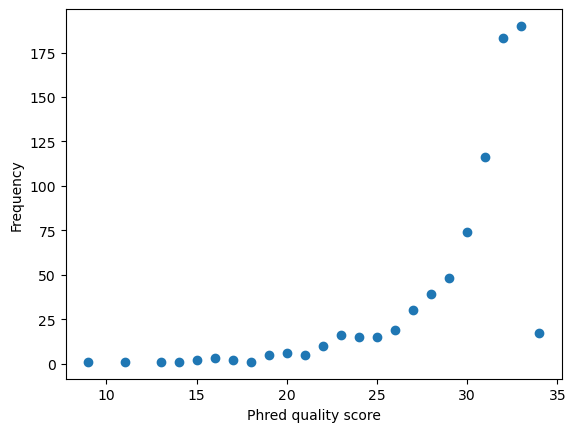

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

hist_data = read_histogram_dict(readset)
plt.scatter(hist_data.keys(), hist_data.values())
plt.xlabel('Phred quality score')
plt.ylabel('Frequency')
plt.show()

<br>

Alternatively, you could directly use the `plt.hist()` function in `matplotlib`.

This function takes the data values you want to bin, and the intervals you want to put them in. But you should provide the bins in order with `sorted()`.


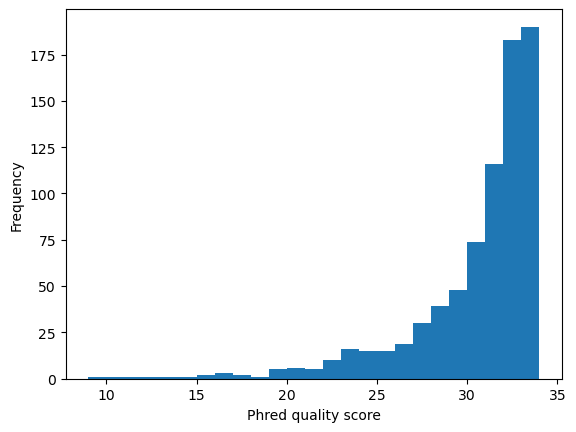

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

# Get the read qualities
read_qualities = [read_quality(r) for r in readset]

# Define the intervals [i,i+1)
distribution_keys = [np.floor(r) for r in read_qualities]

# Include the upper bound of the last interval
# distribution_keys.append(max(sorted(distribution_keys))+1)

# Plot
plt.hist(read_qualities, sorted(distribution_keys))
plt.xlabel('Phred quality score')
plt.ylabel('Frequency')
plt.show()

<br>

We can also change the colour, overlay lines, and edit the appearance of the plot. 

Change some of the arguments (`fontsize`, `labelpad` or `color`) below to see what effect they have.

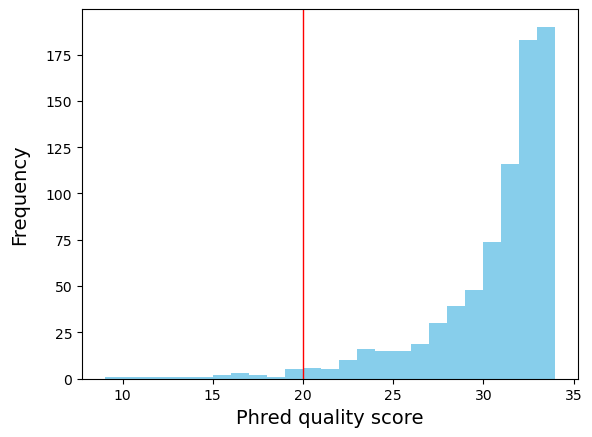

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot
plt.hist(read_qualities, sorted(distribution_keys), color="skyblue")
plt.xlabel('Phred quality score', fontsize=14)
plt.ylabel('Frequency', fontsize=14, labelpad=12)
plt.axvline(x=20,linewidth=1, color='r')
plt.show()

<br>

You can also make other plot types, like boxplots.

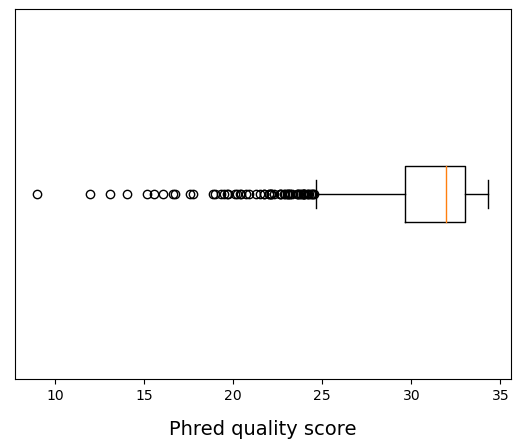

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot
plt.boxplot(read_qualities, vert=False)
plt.xlabel('Phred quality score', fontsize=14, labelpad=12)
plt.yticks([])
plt.show()

<br>

The documentation for these functions can be found here:
> https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html

> https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html

> https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.boxplot.html

A list of colour names can be found here:
> https://matplotlib.org/stable/gallery/color/named_colors.html

## Task 4 - Using FastQC for quality control

<div class="info">
The above analysis and more can be performed using the [FastQC tool](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/). 


If you wish to install FastQC on a (Mac or Linux) personal device, use the conda command `conda install -c bioconda fastqc`.


The documentation for FastQC can be found here:
> https://www.bioinformatics.babraham.ac.uk/projects/fastqc/

</div>

**Please execute the command below to run FastQC.**

In [39]:
# Run FastQC on the ERR024571_1 dataset.
!fastqc -o ./ ERR024571_1.fastq.gz

application/octet-stream
Started analysis of ERR024571_1.fastq.gz
Approx 5% complete for ERR024571_1.fastq.gz
Approx 10% complete for ERR024571_1.fastq.gz
Approx 15% complete for ERR024571_1.fastq.gz
Approx 20% complete for ERR024571_1.fastq.gz
Approx 25% complete for ERR024571_1.fastq.gz
Approx 30% complete for ERR024571_1.fastq.gz
Approx 35% complete for ERR024571_1.fastq.gz
Approx 40% complete for ERR024571_1.fastq.gz
Approx 45% complete for ERR024571_1.fastq.gz
Approx 50% complete for ERR024571_1.fastq.gz
Approx 55% complete for ERR024571_1.fastq.gz
Approx 60% complete for ERR024571_1.fastq.gz
Approx 65% complete for ERR024571_1.fastq.gz
Approx 70% complete for ERR024571_1.fastq.gz
Approx 75% complete for ERR024571_1.fastq.gz
Approx 80% complete for ERR024571_1.fastq.gz
Approx 85% complete for ERR024571_1.fastq.gz
Approx 90% complete for ERR024571_1.fastq.gz
Approx 95% complete for ERR024571_1.fastq.gz
Analysis complete for ERR024571_1.fastq.gz


Open the ERR024571_1_fastqc.html file to see the FastQC report.


###  What does this all mean?

The report provides information about several QC metrics.

You should refer to this documentation to help you figure out what some of the metrics mean: 
>https://www.bioinformatics.babraham.ac.uk/projects/fastqc/


There is also a FastQC report explanation video on the LMS in the week 2 module.



<div class="question">
1. How many reads are in the read set?
</div>


358610

<div class="question">
2. How long are the reads?
</div>


76

<div class="question">
3. Are all the reads the same length?
</div>


No

<div class="question">
4. How are the quality scores distributed across the length of the reads?
</div>


-- GRADED CELL (1 mark) - complete this cell --

YOUR ANSWER HERE

<div class="question">
5. Are there any overrepresented sequences?
</div>


Yes
GATCGGAAGAGCTCGTATGCCGTCTTCTGCTTGGATCGGAAGAGCACACG
Proportion: 0.3248654527202253

<div class="question">
6. What is the likely source of the overrepresented sequences?
</div>


Illumina Single End Adapter 1 (100% over 33bp)

<div class="question">
7. Overall, is this read set of acceptable quality?
</div>


Yes

### Some comments about quality control

What we have covered in this workshop is just one layer of quality control. 

Further QC would need to be done, depending on the type of analysis. QC should form an important component of all analyses. Ultimately, it can save a lot of time and effort!



FastQC outputs a report for an individual FASTQ file. If you are dealing with multiple read sets in your own projects, MultiQC provides a summary of all FastQC reports. See https://multiqc.info/ and have a look at the example reports.

`Workshop developed by Steven Morgan, Dr Dieter Bulach, Dharmesh Bhuva, Holly Whitfield and Adam Taranto.`